## Modelo de Regresión Logística
Este modelo se va a aplicar a datos del intrumento EURUSDT bajados de la API de Binance.  
Voy a usar el código sugerido por Copilot

In [1]:
# Se realizan las importaciones necesarias
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
1
 
plt.style.use("seaborn-v0_8-whitegrid")

In [2]:
# obtención de los datos
data = pd.read_csv("EURUSDT_2020_5min.csv")
data = data.rename(columns = {"Close time": "time", "Close": "price"})
data["time"] = pd.to_datetime(data["time"])
data.set_index("time", inplace=True)

In [3]:
data

,price
time,
2020-01-03 08:04:59.999,1.1188
2020-01-03 08:09:59.999,1.1188
2020-01-03 08:14:59.999,1.1188
2020-01-03 08:19:59.999,1.1196
2020-01-03 08:24:59.999,1.1196
...,...
2020-12-30 23:44:59.999,1.2311
2020-12-30 23:49:59.999,1.2310
2020-12-30 23:54:59.999,1.2309


In [4]:
# este cálculo establece los rendimientos de B/H
data["returns"] = np.log(data["price"] / data["price"].shift(1))

In [5]:
data

,price,returns
time,,
2020-01-03 08:04:59.999,1.1188,NaN
2020-01-03 08:09:59.999,1.1188,0.000000
2020-01-03 08:14:59.999,1.1188,0.000000
2020-01-03 08:19:59.999,1.1196,0.000715
2020-01-03 08:24:59.999,1.1196,0.000000
...,...,...
2020-12-30 23:44:59.999,1.2311,-0.000081
2020-12-30 23:49:59.999,1.2310,-0.000081
2020-12-30 23:54:59.999,1.2309,-0.000081


In [6]:
# eliminar datos nulos
data.dropna(inplace=True)

In [7]:
# solo nos interesa la dirección del mercado
data["direction"] = np.sign(data["returns"])

In [8]:
data

,price,returns,direction
time,,,
2020-01-03 08:09:59.999,1.1188,0.000000,0.0
2020-01-03 08:14:59.999,1.1188,0.000000,0.0
2020-01-03 08:19:59.999,1.1196,0.000715,1.0
2020-01-03 08:24:59.999,1.1196,0.000000,0.0
2020-01-03 08:29:59.999,1.1159,-0.003310,-1.0
...,...,...,...
2020-12-30 23:44:59.999,1.2311,-0.000081,-1.0
2020-12-30 23:49:59.999,1.2310,-0.000081,-1.0
2020-12-30 23:54:59.999,1.2309,-0.000081,-1.0


In [9]:
data.direction.value_counts()

direction
 0.0    36592
 1.0    33987
-1.0    33616
Name: count, dtype: int64

In [10]:
"""Arriba se observa que la clase 0 es dominante, a sugerencia de copilot se va 
a eliminar"""
data = data[data["direction"] != 0]

Ahora se van a generar los roles o características (variables independientes). Serán 5 variables independientes que se obtienen con los 5 períodos anteriores, además se eliminan los valores nulos generados por las lags

In [11]:
lags = 5
for lag in range(1, lags + 1):
    data[f"lag{lag }"] = data["returns"].shift(lag)
data.dropna(inplace=True)

C:\Users\marioL\AppData\Local\Temp\ipykernel_15340\265134036.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"lag{lag }"] = data["returns"].shift(lag)
C:\Users\marioL\AppData\Local\Temp\ipykernel_15340\265134036.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"lag{lag }"] = data["returns"].shift(lag)
C:\Users\marioL\AppData\Local\Temp\ipykernel_15340\265134036.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [12]:
data

,price,returns,direction,lag1,lag2,lag3,lag4,lag5
time,,,,,,,,
2020-01-03 09:39:59.999,1.1175,-0.000626,-1.0,-0.000894,0.000089,0.002864,-0.003310,0.000715
2020-01-03 09:59:59.999,1.1151,-0.002150,-1.0,-0.000626,-0.000894,0.000089,0.002864,-0.003310
2020-01-03 11:04:59.999,1.1136,-0.001346,-1.0,-0.002150,-0.000626,-0.000894,0.000089,0.002864
2020-01-03 11:09:59.999,1.1151,0.001346,1.0,-0.001346,-0.002150,-0.000626,-0.000894,0.000089
2020-01-03 11:34:59.999,1.1141,-0.000897,-1.0,0.001346,-0.001346,-0.002150,-0.000626,-0.000894
...,...,...,...,...,...,...,...,...
2020-12-30 23:44:59.999,1.2311,-0.000081,-1.0,-0.000162,0.000162,-0.000162,0.000406,0.000406
2020-12-30 23:49:59.999,1.2310,-0.000081,-1.0,-0.000081,-0.000162,0.000162,-0.000162,0.000406
2020-12-30 23:54:59.999,1.2309,-0.000081,-1.0,-0.000081,-0.000081,-0.000162,0.000162,-0.000162


También se normalizan las variables independientes para que el modelo no se vea afectado debido a escalas diferentes en los datos  

In [13]:
X = data[[f"lag{lag}" for lag in range(1, lags + 1)]]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

In [14]:
type(X)

pandas.core.frame.DataFrame

In [15]:
# variable dependiente u objetivo
y = data["direction"]

In [16]:
# instanciar y entrenar el modelo
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression(C=1e6, max_iter = 100000)
lm.fit(x_scaled, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1000000.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100000
,multi_class,'deprecated'


In [17]:
# imprimir coeficientes e intercepción
print("coeficientes:", lm.coef_)
print("intercepción:", lm.intercept_)

coeficientes: [[-0.74111345 -0.40106235 -0.2623377  -0.13502582 -0.077608  ]]
intercepción: [0.0113822]


In [18]:
# realizar predicciones
data["pred"] = lm.predict(x_scaled)

C:\Users\marioL\AppData\Local\Temp\ipykernel_15340\3854583767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["pred"] = lm.predict(x_scaled)


In [23]:
data.pred.value_counts()

pred
 1.0    34842
-1.0    32756
Name: count, dtype: int64

Aparentemente, al eliminar la clase 0, se han obtenido resultados para la predicción de la dirección del mercado con una ligera dominancia del mercado al alza.  
A continuación se genera un archivo CSV para guardar los resultados de los cálculos.

In [20]:
# convertir x_scaled a dataframe
x_scaled_df = pd.DataFrame(x_scaled, index=X.index, columns=X.columns)

In [21]:
# unir X, x_scaled, y y la columna pred de data en un solo dataframe
result = pd.concat([X, x_scaled_df.add_suffix("_scaled"),
                    y.rename("direction"), data["pred"].rename("pred")], axis=1)

In [22]:
# guardar el dataframe combinado en un archivo CSV
result.to_csv("backtest_results.csv")

Comparación de las realizaciones de B/H y la estrategia con el modelo de Regresión Logística.  
Se calculan los rendimientos acumulados de las dos estrategias.

In [24]:
data

,price,returns,direction,lag1,lag2,lag3,lag4,lag5,pred
time,,,,,,,,,
2020-01-03 09:39:59.999,1.1175,-0.000626,-1.0,-0.000894,0.000089,0.002864,-0.003310,0.000715,1.0
2020-01-03 09:59:59.999,1.1151,-0.002150,-1.0,-0.000626,-0.000894,0.000089,0.002864,-0.003310,1.0
2020-01-03 11:04:59.999,1.1136,-0.001346,-1.0,-0.002150,-0.000626,-0.000894,0.000089,0.002864,1.0
2020-01-03 11:09:59.999,1.1151,0.001346,1.0,-0.001346,-0.002150,-0.000626,-0.000894,0.000089,1.0
2020-01-03 11:34:59.999,1.1141,-0.000897,-1.0,0.001346,-0.001346,-0.002150,-0.000626,-0.000894,1.0
...,...,...,...,...,...,...,...,...,...
2020-12-30 23:44:59.999,1.2311,-0.000081,-1.0,-0.000162,0.000162,-0.000162,0.000406,0.000406,1.0
2020-12-30 23:49:59.999,1.2310,-0.000081,-1.0,-0.000081,-0.000162,0.000162,-0.000162,0.000406,1.0
2020-12-30 23:54:59.999,1.2309,-0.000081,-1.0,-0.000081,-0.000081,-0.000162,0.000162,-0.000162,1.0


In [25]:
data["strategy"] = data.pred * data.returns

C:\Users\marioL\AppData\Local\Temp\ipykernel_15340\1248937007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["strategy"] = data.pred * data.returns


In [26]:
data["creturns"] = data["returns"].cumsum().apply(np.exp)
data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)


C:\Users\marioL\AppData\Local\Temp\ipykernel_15340\3726588414.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["creturns"] = data["returns"].cumsum().apply(np.exp)
C:\Users\marioL\AppData\Local\Temp\ipykernel_15340\3726588414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)


<Axes: xlabel='time'>

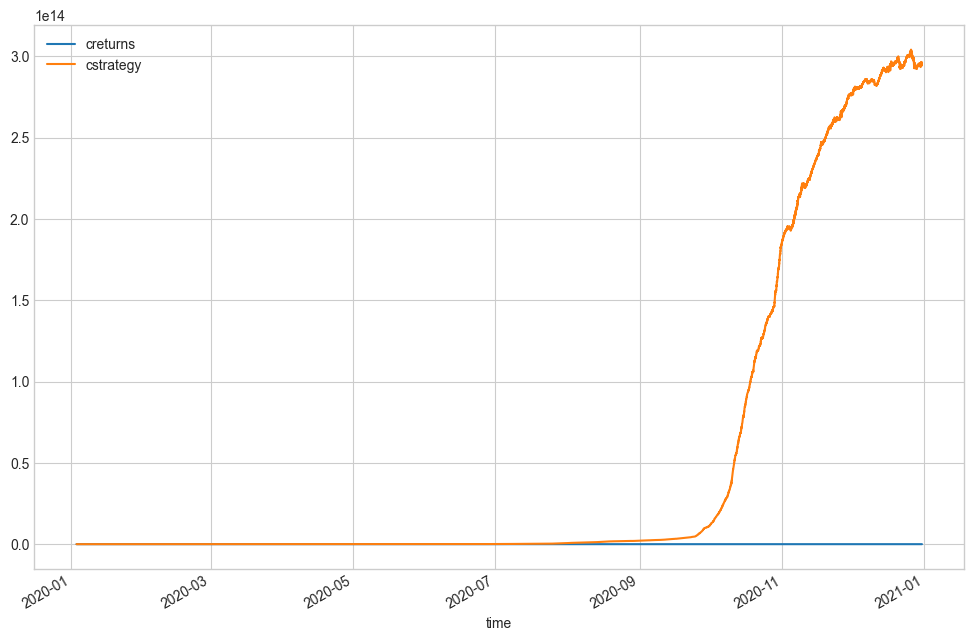

In [27]:
data[["creturns", "cstrategy"]].plot(figsize=(12, 8))

Aparentemente, hubo una sobre-realización de la estrategia con el modelo de Regresión Logística a partir del mes de octubre.  
Como la clase 0 fué eliminada antes, voy a recalcular incluyendo esta clase.